In [14]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import DataLoader
import csv
import random
import numpy as np
import cv2
import mimetypes
import fnmatch
import seaborn as sns
from collections import Counter, defaultdict
import torchvision
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import time
from progress.bar import IncrementalBar
from tqdm.notebook import tqdm_notebook
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

### Create of a dataset class

In [15]:
labels_map_1 = {
    "Benign": 0,
    "InSitu": 1,
    "Invasive": 2,
}

In [16]:
class ImageDataset(Dataset):
    def __init__(self, annotations_file, paths_file, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        f = open(paths_file, 'r')
        self.img_paths = f.read().split('\n')
        f.close()
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = read_image(img_path)
        img_folder = int(img_path.split("/")[1])
        label_name = self.img_labels.iloc[img_folder - 1][4]
        label = torch.tensor(labels_map_1[label_name])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        image = image.float()
        return image, label

In [17]:
# with open("path/to/file.ext", "r") as file:
#     ...

In [5]:
with open('paths.txt', 'r') as file:
    img_paths = file.read().split('\n')
    
little_train_paths = np.array(img_paths[0:30000])

with open('little_train_paths.txt', 'r') as file:
    for i in range(little_train_paths.shape[0] - 1):
        file.write(little_train_paths[i] + '\n')  
    file.write(little_train_paths[little_train_paths.shape[0] - 1])

Feature batch shape: torch.Size([128, 3, 256, 256])
Labels batch shape: 128
torch.Size([256, 256, 3])


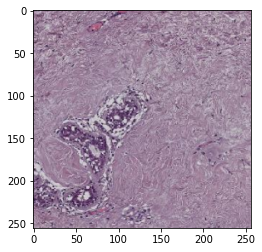

Label: 0


In [6]:
transform = transforms.Resize([256, 256])
little_dataset = ImageDataset('burnasyan_Br.csv', 'little_train_paths.txt', transform = transform)
little_dataloader = DataLoader(little_dataset, batch_size=128, shuffle=True)
features_l, labels_l = next(iter(little_dataloader))
print(f"Feature batch shape: {features_l.size()}")
print(f"Labels batch shape: {len(labels_l)}")
img = features_l[0].squeeze().permute(1, 2, 0).int()
print(img.shape)
label = labels_l[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [8]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(95256, 1024)
        self.fc3 = nn.Linear(1024, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return x


conv_net = ConvNet().to(device)
print(conv_net)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=95256, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=3, bias=True)
)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(conv_net.parameters(), lr=1e-5, momentum=0.9)

In [10]:
answers = []
true_answers = []

for epoch in tqdm_notebook(range(2), desc='epochs'):  # loop over the dataset multiple times

    running_loss = 0.0
    i = 0
    for data in tqdm_notebook(little_dataloader, desc='one epoch training'):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        true_answers.append(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = conv_net(inputs)
        answers.append(nn.Softmax(dim=1)(outputs))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0
        i += 1

print('Finished Training')

net training:   0%|          | 0/2 [00:00<?, ?it/s]

collecting data:   0%|          | 0/235 [00:00<?, ?it/s]

[1,    50] loss: 0.740
[1,   100] loss: 0.715
[1,   150] loss: 0.741
[1,   200] loss: 0.729


collecting data:   0%|          | 0/235 [00:00<?, ?it/s]

[2,    50] loss: 0.688
[2,   100] loss: 0.671
[2,   150] loss: 0.673
[2,   200] loss: 0.675
Finished Training


In [11]:
ans = []
for i in range(len(answers)):
    answers[i] = answers[i].to('cpu')
    for item in answers[i]:
        ans.append(item.detach().numpy()) 
ans = np.array(ans, dtype=object).astype(float)

# our predictions
pred_classes = np.argmax(ans, axis = 1)

In [12]:
true_ans = []
for i in range(len(true_answers)):
    true_answers[i] = true_answers[i].to('cpu')
    for item in true_answers[i]:
        true_ans.append(item.item()) 
true_classes = np.array(true_ans, dtype=np.int64)

In [13]:
cf_matrix = confusion_matrix(true_classes, pred_classes)

<AxesSubplot:>

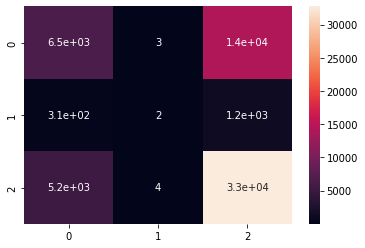

In [14]:
sns.heatmap(cf_matrix, annot=True)

In [15]:
# Accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(true_classes, pred_classes))

# Recall
from sklearn.metrics import recall_score
print(recall_score(true_classes, pred_classes, average=None))

# Precision
from sklearn.metrics import precision_score
print(precision_score(true_classes, pred_classes, average=None))

0.654
[0.31515505 0.00133869 0.86349257]
[0.54191392 0.22222222 0.68200558]


In [16]:
from sklearn.metrics import roc_auc_score
roc_auc_score(true_classes, ans, multi_class='ovr', average='weighted')

0.686418213135029

### Experiment with TensorBoard

In [9]:
# classes = ('Benign', 'InSitu', 'Invasive')

In [8]:
transform = transforms.Resize([256, 256])
dataset = ImageDataset('burnasyan_Br.csv', 'little_train_paths.txt', transform = transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
features, labels = next(iter(dataloader))
features = features.to(device)
labels = labels.to(device)

In [9]:
# helper functions

# def matplotlib_imshow(img):
#     npimg = img.cpu().detach().numpy()
#     plt.imshow(np.transpose((npimg * 255).astype(np.uint8), (1, 2, 0)))
    
# def images_to_probs(net, images):
#     '''
#     Generates predictions and corresponding probabilities from a trained
#     network and a list of images
#     '''
#     output = net(images)
#     # convert output probabilities to predicted class
#     _, preds_tensor = torch.max(output, 1)
#     preds = np.squeeze(preds_tensor.cpu().detach().numpy())
#     return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


# def plot_classes_preds(net, images, labels):
#     '''
#     Generates matplotlib Figure using a trained network, along with images
#     and labels from a batch, that shows the network's top prediction along
#     with its probability, alongside the actual label, coloring this
#     information based on whether the prediction was correct or not.
#     Uses the "images_to_probs" function.
#     '''
#     preds, probs = images_to_probs(net, images)
#     # plot the images in the batch, along with predicted and true labels
#     fig = plt.figure(figsize=(12, 48))
#     for idx in np.arange(4):
#         ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
#         matplotlib_imshow(images[idx])
#         ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
#             classes[preds[idx]],
#             probs[idx] * 100.0,
#             classes[labels[idx]]),
#                     color=("green" if preds[idx]==labels[idx].item() else "red"))
#     return fig

def get_true_classes(input_classes):
    true_classes = []
    for i in range(len(input_classes)):
        input_classes[i] = input_classes[i].to('cpu')
        for item in input_classes[i]:
            true_classes.append(item.item()) 
    out = np.array(true_classes, dtype=np.int64)
    return out

def get_predicted_classes(input_classes):
    pred_classes = []
    for i in range(len(input_classes)):
        input_classes[i] = input_classes[i].to('cpu')
        for item in input_classes[i]:
            pred_classes.append(item.detach().numpy()) 
    pred_classes = np.array(pred_classes, dtype=object).astype(float)
    out = np.argmax(pred_classes, axis = 1)
    return out

In [12]:
writer = SummaryWriter('runs/1CNN_training')
writer.add_graph(conv_net, features)

/home/anna/Desktop/workenv/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [17]:
classes = []
true_classes= []

for epoch in tqdm_notebook(range(2), desc='epochs'):  # loop over the dataset multiple times

    running_loss = 0.0
    i = 0
    for data in tqdm_notebook(dataloader, desc='one epoch training'):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        true_classes.append(labels)
        write_true_classes = get_true_classes(true_classes)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = conv_net(inputs)
        classes.append(nn.Softmax(dim=1)(outputs))
        write_pred_classes = get_predicted_classes(classes)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches
            # log the running loss
            writer.add_scalar('training loss',
                            running_loss / 20,
                            epoch * len(dataloader) + i)
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 20))
            writer.add_scalar('Accuracy', 
                              accuracy_score(write_true_classes, write_pred_classes),
                              epoch * len(dataloader) + i)
            running_loss = 0.0
        i += 1

print('Finished Training')

epochs:   0%|          | 0/2 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/469 [00:00<?, ?it/s]

[1,    20] loss: 0.622
[1,    40] loss: 0.647
[1,    60] loss: 0.588
[1,    80] loss: 0.641
[1,   100] loss: 0.591
[1,   120] loss: 0.626
[1,   140] loss: 0.626
[1,   160] loss: 0.638
[1,   180] loss: 0.610
[1,   200] loss: 0.589
[1,   220] loss: 0.630
[1,   240] loss: 0.616
[1,   260] loss: 0.613
[1,   280] loss: 0.609
[1,   300] loss: 0.610
[1,   320] loss: 0.617
[1,   340] loss: 0.609
[1,   360] loss: 0.598
[1,   380] loss: 0.598
[1,   400] loss: 0.591
[1,   420] loss: 0.634
[1,   440] loss: 0.624
[1,   460] loss: 0.643


one epoch training:   0%|          | 0/469 [00:00<?, ?it/s]

[2,    20] loss: 0.578
[2,    40] loss: 0.579
[2,    60] loss: 0.560
[2,    80] loss: 0.578
[2,   100] loss: 0.561
[2,   120] loss: 0.544
[2,   140] loss: 0.565
[2,   160] loss: 0.556
[2,   180] loss: 0.554
[2,   200] loss: 0.545
[2,   220] loss: 0.550
[2,   240] loss: 0.549
[2,   260] loss: 0.593
[2,   280] loss: 0.566
[2,   300] loss: 0.541
[2,   320] loss: 0.563
[2,   340] loss: 0.596
[2,   360] loss: 0.602
[2,   380] loss: 0.587
[2,   400] loss: 0.568
[2,   420] loss: 0.586
[2,   440] loss: 0.553
[2,   460] loss: 0.543
Finished Training
